In [1]:
import torch
from torchvision import transforms
import torch.nn as nn
import numpy as np
import os
import sys
from glob import glob
import collections

In [2]:
from classifier_networks import VGG, vgg_layers, CNN
from GAN_models.gan_load import make_style_gan2

from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [3]:
#import seaborn as sns
import pandas as pd

In [4]:
device = torch.device('cuda:0')

In [5]:
class Args:
    def __init__(self):
        self.gan_weights= 'GAN_models/pretrained/generators/StyleGAN2/stylegan2-ffhq-config-f.pt'
        self.classifier_weights= 'classifier_weights/celebA_MultiLabels_vgg11_classifier.pt'
        self.classifier_network= 'VGG'
        self.class_count= 39
        self.latent_dim= 512
        self.scale_loss_ratio= 0.03 #faithfulness
        self.gan_output_dim= 1024
        self.gan_output_channel= 3
        self.classifier_input_dim= 256
        self.classifier_input_channel=3
        self.batch_size= 1
        self.n_steps= 100000
        self.lr= 1e-4
        self.batch_noise_scale= 0.1
        #self.training_name= 'FACE_Multi'
        #self.multi_task = True
        self.shift_model_weight = 'weights/FACE_0.030_1_38_17_8_AdityaAttrs_v2.pt'
        #self.subset_labels = [1,25,11,17,28,27,34,16,3] #add attracitve# Pale_Skin, Bushy_Eyebrows, Heavy_Makeup, Rosy_Cheeks, Receding_hairline, Wearing_Hat, Gray_Hair, Bald
        #self.subset_labels = [38,17,1,19,14,8,18,21,3] #add attracitve# Young, Male, Heavy_Makeup, Eyeglasses, Blond_Hair, High_Cheekbones, Mustache, Bald
        self.subset_labels = [1,38,17,8] #add attracitve Young Heavy_Makeup, Blond_Hair
        self.target_label = [1] # Attractiveness
args = Args()

In [6]:
all_labels = np.load('./celebA_labels.npy') # the list of labels for CelebA dataset
labels = np.array(all_labels)[args.subset_labels+args.target_label] 
print(all_labels)

['Arched_Eyebrows' 'Attractive' 'Bags_Under_Eyes' 'Bald' 'Bangs'
 'Big_Lips' 'Big_Nose' 'Black_Hair' 'Blond_Hair' 'Blurry' 'Brown_Hair'
 'Bushy_Eyebrows' 'Chubby' 'Double_Chin' 'Eyeglasses' 'Goatee' 'Gray_Hair'
 'Heavy_Makeup' 'High_Cheekbones' 'Male' 'Mouth_Slightly_Open' 'Mustache'
 'Narrow_Eyes' 'No_Beard' 'Oval_Face' 'Pale_Skin' 'Pointy_Nose'
 'Receding_Hairline' 'Rosy_Cheeks' 'Sideburns' 'Smiling' 'Straight_Hair'
 'Wavy_Hair' 'Wearing_Earrings' 'Wearing_Hat' 'Wearing_Lipstick'
 'Wearing_Necklace' 'Wearing_Necktie' 'Young']


In [7]:
GAN_weight_file = args.gan_weights
gan_resolution = args.gan_output_dim

classifier_weight_file = args.classifier_weights
classifier_network = args.classifier_network
class_count = args.class_count
classifier_input_size = 256
latent_size = args.latent_dim

#number of attributes
attribute_count = len(args.subset_labels)

batch_size = 1
print(class_count)

39


In [8]:
resize_transform = transforms.Scale((classifier_input_size,classifier_input_size)) # A transformation to resize images from GAN output to classifier input

/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [9]:
class FCShiftPredictor(nn.Module):
    def __init__(self,input_dim,class_dim, inner_dim, output_dim):
        super(FCShiftPredictor, self).__init__()
        self.fc_direction = nn.Sequential(
            nn.Linear(input_dim+class_dim,inner_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(inner_dim,inner_dim),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(inner_dim,output_dim),
        )
        
    def forward(self, x,c):
        x_c = torch.cat((x,c),1)
        dir_ = self.fc_direction(x_c)
        return dir_

In [10]:
# Load the shift predictor
shift_model = torch.load(args.shift_model_weight)
shift_model = shift_model.eval()

In [11]:
# Load GAN model
G = make_style_gan2(gan_resolution, GAN_weight_file)
G.eval()
G = G.to(device)

In [12]:
# Load the classifier
classifier_weights = torch.load(classifier_weight_file)

if isinstance(classifier_weights, collections.OrderedDict):
    if classifier_network == 'VGG':
        classifier = VGG(vgg_layers,class_count)
    elif classifier_network == 'CNN':
        classifier = CNN()
    elif classifier_network == 'ResNet50':
        raise ValueError('Classifier architecture {} is not imlplemented.'.format(classifier_network))
    else:
        raise ValueError('Classifier architecture {} is not defined.'.format(classifier_network))
    classifier.load_state_dict(classifier_weights)

elif isinstance(classifier_weights,dict):
    if 'model' in classifier_weights:
        classifier_weights = classifier_weights['model']
    else:
        print('Classifier weights file includes:',classifier_weights.keys())
        raise ValueError('Classifier weight file has an unknown format.')
else:
    classifier = classifier_weights

classifier = classifier.to(device)
classifier = classifier.eval()

In [13]:
def get_sample_W_y(plot=True):#add functionality to plot this original sample
    z_perturb = torch.randn([1,latent_size]).repeat(batch_size,1).to(device)
    w = G.style_gan2.get_latent(z_perturb)
    img_orig = G.style_gan2([w], input_is_latent=True)[0]
    img_orig = resize_transform(img_orig)
    y_orig = classifier(img_orig)
    #print(y_orig)
    y_orig = torch.sigmoid(y_orig[0])
    #print(y_orig)
    if plot:
        plt.imshow(img_orig[0].permute(1,2,0).detach().cpu().numpy())
        print(y_orig[0][1])
    return w,y_orig[0][1]#1 is attratcive according to all_labels read from npy file
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.7893, device='cuda:0', grad_fn=<SelectBackward>)


(tensor([[ 2.1990e-01, -8.6682e-02,  1.1504e+00, -1.0351e-01, -1.4929e-01,
          -5.1702e-01, -9.7306e-02, -1.1205e-01, -1.6647e-01, -5.7881e-02,
          -1.4279e-01,  8.6131e-02, -2.6293e-02, -3.4691e-01,  2.0746e-01,
           4.9999e-01, -3.4416e-02, -9.1206e-02, -2.1807e-02,  7.7213e-01,
          -4.0091e-02,  8.5449e-01,  3.1844e-01, -1.0242e-01,  5.0293e-01,
          -4.1597e-02, -1.0274e-01, -1.3956e-01,  5.5565e-02,  9.5910e-01,
          -1.7477e-01,  5.8232e-01,  9.4150e-01, -2.0907e-01, -1.6859e-01,
          -5.5888e-02, -3.0468e-01, -2.5082e-01, -1.9628e-01,  5.0100e-02,
          -1.6385e-01, -1.4659e-01, -4.1811e-02, -2.0936e-01,  1.3314e+00,
          -1.6891e-01,  5.0958e-01, -5.0215e-01, -2.1574e-02, -1.9044e-01,
           4.9732e-01,  8.4367e-01,  5.5200e-01, -1.2465e-01, -1.9915e-01,
          -2.2242e-01,  3.3615e-01,  8.9701e-01, -3.7314e-01, -2.1855e-01,
           8.5767e-01,  8.7311e-02, -2.1611e-01, -1.6957e-01,  1.4883e+00,
          -3.1470e-02,  3

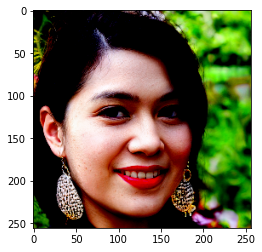

In [14]:
get_sample_W_y()

In [15]:
ft_map={1:"Attractive",
       38:"Young",
       17:"Heavy_Makeup",
       8:"Blond_Hair"}
grand_coalition= [38,17,8]#remove attractive 1

In [16]:
def shift(w,S,gc):#shift original w in dorections of features in set S
    if len(S)==0:#:
        w_i=w #no shift
        img = G.style_gan2([w_i], input_is_latent=True)[0]
        img = resize_transform(img)
        y = classifier(img)
        #print(y[0])
        y = torch.sigmoid(y[0])
        y = y[0][1]
        print("Emoty set y",y)
        return w_i, y
        #y = y.cpu().detach().numpy()
        #return w_i,y[-1]
    
    y_target = torch.zeros(attribute_count).to(device)#--y_target will be generated based on S
    for each_ft in gc:
        if each_ft in S:
            y_target[gc.index(each_ft)]=0 #keep it same if in coalition
        else:
            y_target[gc.index(each_ft)]=-1 #reduce or switch off if not in coalition

    y_target=y_target.reshape(1,-1)

    dir_pred = shift_model(w,y_target)
    #print("DIR PRED",dir_pred)
   
    #now create new latent space by going in dir,then new image, and pass thru clf and get output
   
    w_i = w+dir_pred
    
    img = G.style_gan2([w_i], input_is_latent=True)[0]
    img = resize_transform(img)
    
    y = classifier(img)
    y = torch.sigmoid(y[0])
    y=y[0][1]
    if len(S)==len(gc):#plot the gc
        plot_w(w_i)
        print(y)
    
    #print("Y",y,y.shape)
    return w_i, y

    #y = y.cpu().detach().numpy()
    #return w_i,y[-1]#attractiveness target label at last

In [17]:
#individual explanations

In [18]:
def norm_img(img):
    img_np = img[0].permute(1,2,0).cpu().detach().numpy()
    img_norm = (img_np - img_np.min())/(img_np.max() - img_np.min())
    return img_norm

In [19]:
def plot_w(w):
    img = G.style_gan2([w], input_is_latent=True)[0]
    img = resize_transform(img)
    img_norm = norm_img(img)
    plt.imshow(img_norm);
    plt.show();

In [20]:
#do our thing on per image basis

In [21]:
from itertools import compress, product

def combinations(items):
    return ( set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)) )

In [22]:
ft_map

{1: 'Attractive', 38: 'Young', 17: 'Heavy_Makeup', 8: 'Blond_Hair'}

In [23]:
import math
def coalition_wt(N,S):
    num=math.factorial(S)*math.factorial(N-S-1)
    den=math.factorial(N)
    return num/den

In [24]:
def val(S,gc,attribute_count,w):
    #w_rep = w.repeat(attribute_count,1)--no need to repeat
    y_target = torch.zeros(attribute_count).to(device)#--y_target will be generated based on S
    for each_ft in S:
        y_target[gc.index(each_ft)]=1
    y_target=y_target.reshape(1,-1)
    #print(y_target.shape)
    #print(w.shape)
    dir_pred,y_shft = shift(w,S,gc)
    return y_shft

In [25]:
grand_coalition

[38, 17, 8]

In [26]:
ft_map

{1: 'Attractive', 38: 'Young', 17: 'Heavy_Makeup', 8: 'Blond_Hair'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0222, device='cuda:0', grad_fn=<SelectBackward>)


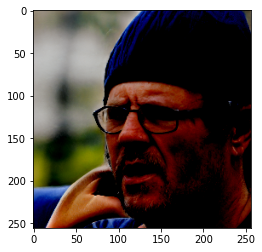

In [27]:
w,y=get_sample_W_y(True)

In [28]:
w.shape

torch.Size([1, 512])

# Try batching

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2452, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2831, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.4258, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0659, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0975, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.2259, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.2914, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1797, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0402, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.2241, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6378, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.7122, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0143, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.6535, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0557, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0322, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5823, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.2303, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3114, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.8549, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0847, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3102, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.6635, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.7696, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3859, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1326, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.5521, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0935, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.7307, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.2868, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3700, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2434, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.4703, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5353, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0308, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.4641, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.2283, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.7722, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3086, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0702, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.8510, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.6156, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1248, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0745, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.2053, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.3972, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0569, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0728, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.3561, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1066, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1343, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3633, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3410, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0540, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0720, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0936, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1542, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3770, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.4488, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3986, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2304, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1740, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3351, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0290, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.4943, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.7669, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.2185, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.2547, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4373, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0099, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.6300, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1216, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1773, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0384, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.2867, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.6047, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1167, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.3676, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3859, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0851, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1367, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1942, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1946, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0321, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.7526, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0561, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0935, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.2150, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0267, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.1814, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3308, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.4438, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.4497, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1620, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1214, device='cuda:0', grad_fn=<SelectBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.0950, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3504, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.3755, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0190, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.0336, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.2277, device='cuda:0', grad_fn=<SelectBackward>)


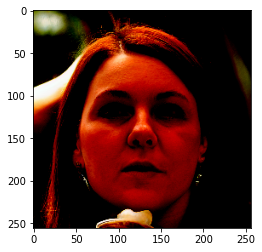

In [27]:
i=100
x,_=get_sample_W_y()
for _ in range(i):
    tmp,_=get_sample_W_y()
    x=torch.vstack((x,tmp))

In [28]:
print(x.shape)

torch.Size([101, 512])


In [29]:
imgs = G.style_gan2([x], input_is_latent=True)[0]

RuntimeError: CUDA out of memory. Tried to allocate 6.31 GiB (GPU 0; 47.54 GiB total capacity; 39.38 GiB already allocated; 4.93 GiB free; 41.11 GiB reserved in total by PyTorch)

In [35]:
imgs.shape

torch.Size([51, 3, 1024, 1024])

In [36]:
imgs = resize_transform(imgs)

In [37]:
imgs.shape

torch.Size([51, 3, 256, 256])

In [38]:
y = classifier(imgs)

In [41]:
y[0].shape

torch.Size([51, 39])

In [ ]:
imgs = G.style_gan2([x], input_is_latent=True)[0]
        img = resize_transform(img)
        y = classifier(img)

# Resume

In [35]:
ft_imp={}

38
Emoty set y tensor(0.6140, device='cuda:0', grad_fn=<SelectBackward>)


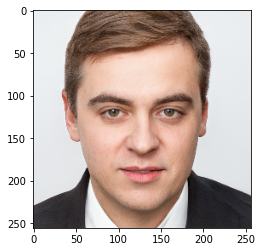

tensor(0.3174, device='cuda:0', grad_fn=<SelectBackward>)
17
Emoty set y tensor(0.6140, device='cuda:0', grad_fn=<SelectBackward>)


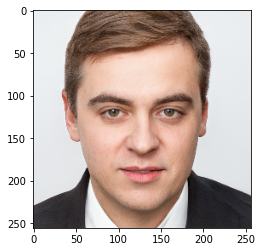

tensor(0.3174, device='cuda:0', grad_fn=<SelectBackward>)
8
Emoty set y tensor(0.6140, device='cuda:0', grad_fn=<SelectBackward>)


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 47.54 GiB total capacity; 45.94 GiB already allocated; 59.56 MiB free; 45.98 GiB reserved in total by PyTorch)

In [36]:
#importance of first feature
#grand_coalition=[38, 17, 19, 14, 8, 18, 21, 3]
grand_coalition=[38,17,8]

for first_ft in list(grand_coalition):
     
    
    print(first_ft)
    phi_i=0
    s_wo_i=set(grand_coalition).difference(set([first_ft]))

    #find all possible subsets of s_wo_i
    all_subsets=list(combinations(s_wo_i))
    #iterate over multiple samples
    
    #go over all subsets, and do val(Sui)-val(S)

    for each_subset in all_subsets:
        torch.cuda.empty_cache()
        v_s=val(each_subset,list(grand_coalition),attribute_count,w)
        v_si=val(set(each_subset).union(set([first_ft])),list(grand_coalition),attribute_count,w)
        
        wt=coalition_wt(len(grand_coalition),len(each_subset))
        
        phi_i+=wt*(v_si-v_s)
    ft_imp[ft_map[first_ft]]=phi_i
    
    

In [37]:
ft_imp

{'Young': tensor(-0.0223, device='cuda:0', grad_fn=<AddBackward0>),
 'Heavy_Makeup': tensor(-0.0269, device='cuda:0', grad_fn=<AddBackward0>)}

In [31]:
ft_imp

{'Young': tensor(0.1875, device='cuda:0', grad_fn=<AddBackward0>),
 'Heavy_Makeup': tensor(0.1305, device='cuda:0', grad_fn=<AddBackward0>),
 'Blond_Hair': tensor(0.0885, device='cuda:0', grad_fn=<AddBackward0>)}

In [32]:
"""import gc
gc.collect()"""

'import gc\ngc.collect()'

In [33]:
"""torch.cuda.empty_cache()"""

'torch.cuda.empty_cache()'